# **WorldQuant University Capstone for MScFE 690 (Group 9184)**

## Data Extraction. Data Transformation. Methodology Description. Reinforcement Learning. Traditional Approaches. Model Development. Performance Comparison and Analysis. DynaCAAST Framework.


<br><br>


|**DynaCAAST framework for RL based trading agents**| |
|:---|:---|
|**TEAM MEMBER 1** | Farai Masunda  |
|**TEAM MEMBER 2**  |      Bhaskar Vedula  |


<hr style='border:4px solid black'>

<hr style='border:2px solid black'>

## **Section 7: Training and testing of traditional and RL agents (Part 1)**


In this section, we train and test all our approaches/agents with the training and testing data that we had created earlier.

In [ ]:
Strategy_Returns_Data_trg = pd.DataFrame()
Strategy_Returns_Data_trg.index = prices_train_data.index[2:]

Strategy_Returns_Data_test = pd.DataFrame()
Strategy_Returns_Data_test.index = prices_test_data.index[2:]
cut_off_date = Strategy_Returns_Data_test.index[0]

In [ ]:
returns_train_data = prices_train_data[tickers_wo_cash].pct_change().dropna()
returns_test_data  = prices_test_data[tickers_wo_cash].pct_change().dropna()
initial_capital    = 100

## **A. Markowitz Mean-Variance Approach**


In [ ]:
# We determine the weights based on the training data

cov_matrix_markow = risk_models.CovarianceShrinkage(prices_train_data[tickers_wo_cash]).ledoit_wolf()
ef = EfficientFrontier(None, cov_matrix_markow, weight_bounds=(0, 1))
ef.min_volatility()
weights_markow = ef.clean_weights()

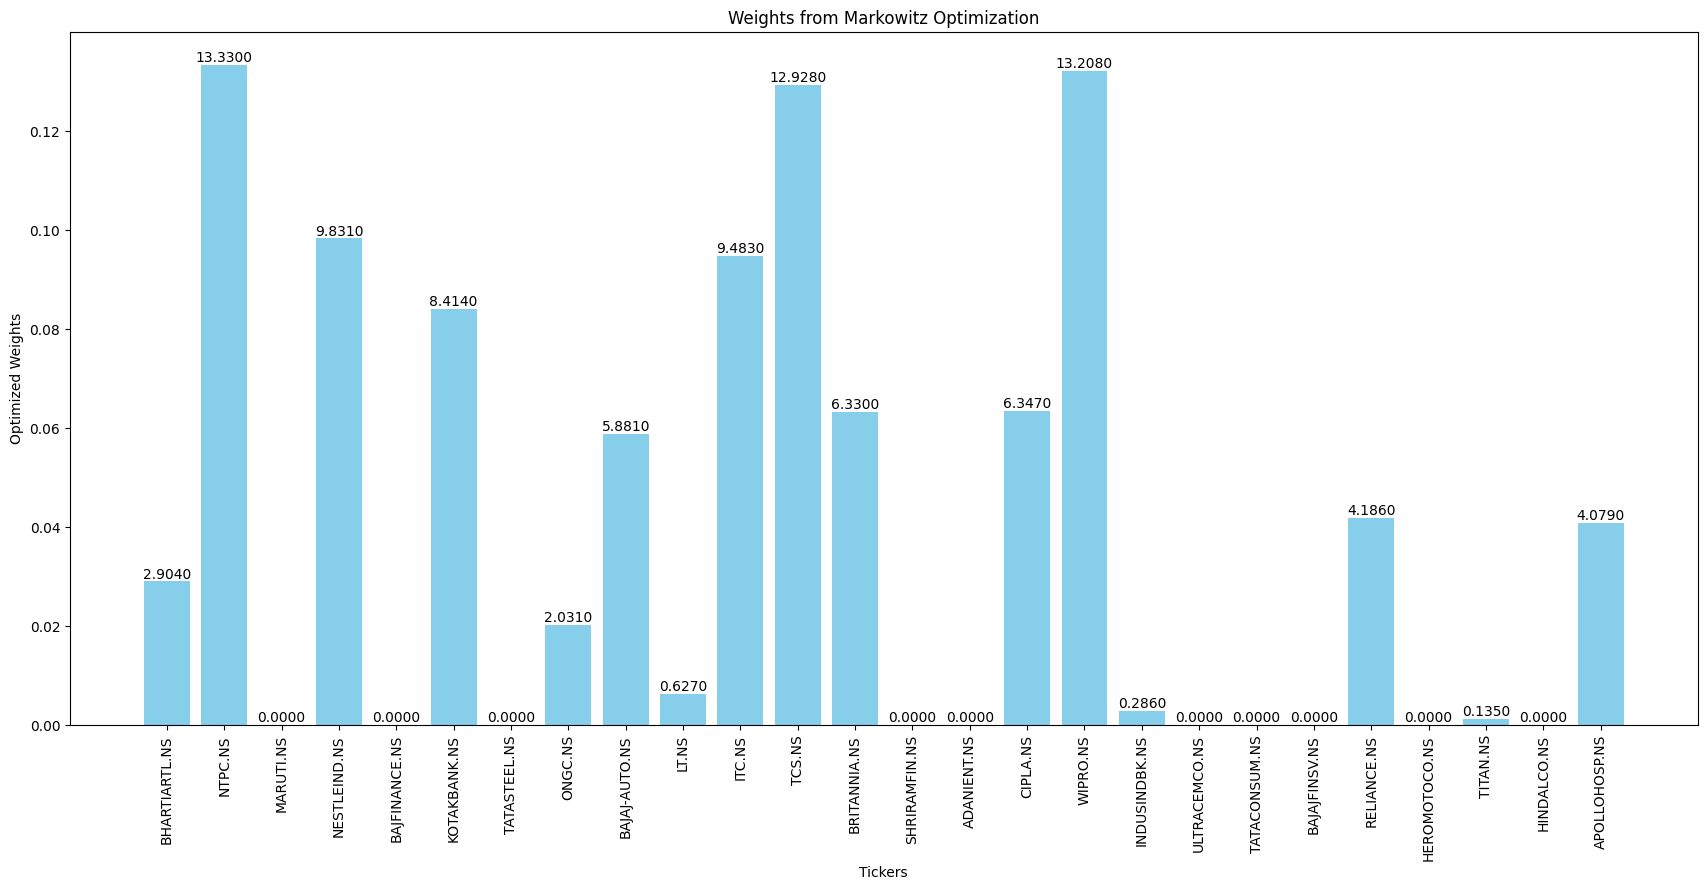

In [ ]:
# Plot the weights
plt.figure(figsize=(21, 9))
bar = plt.bar(weights_markow.keys(), weights_markow.values(), color='skyblue')
plt.xlabel("Tickers")
plt.xticks(tickers_wo_cash)
plt.ylabel("Optimized Weights")
plt.title("Weights from Markowitz Optimization")
plt.bar_label(bar, labels=[f'{x*100:,.4f}' for x in bar.datavalues])
plt.xticks(rotation=90)
plt.show()

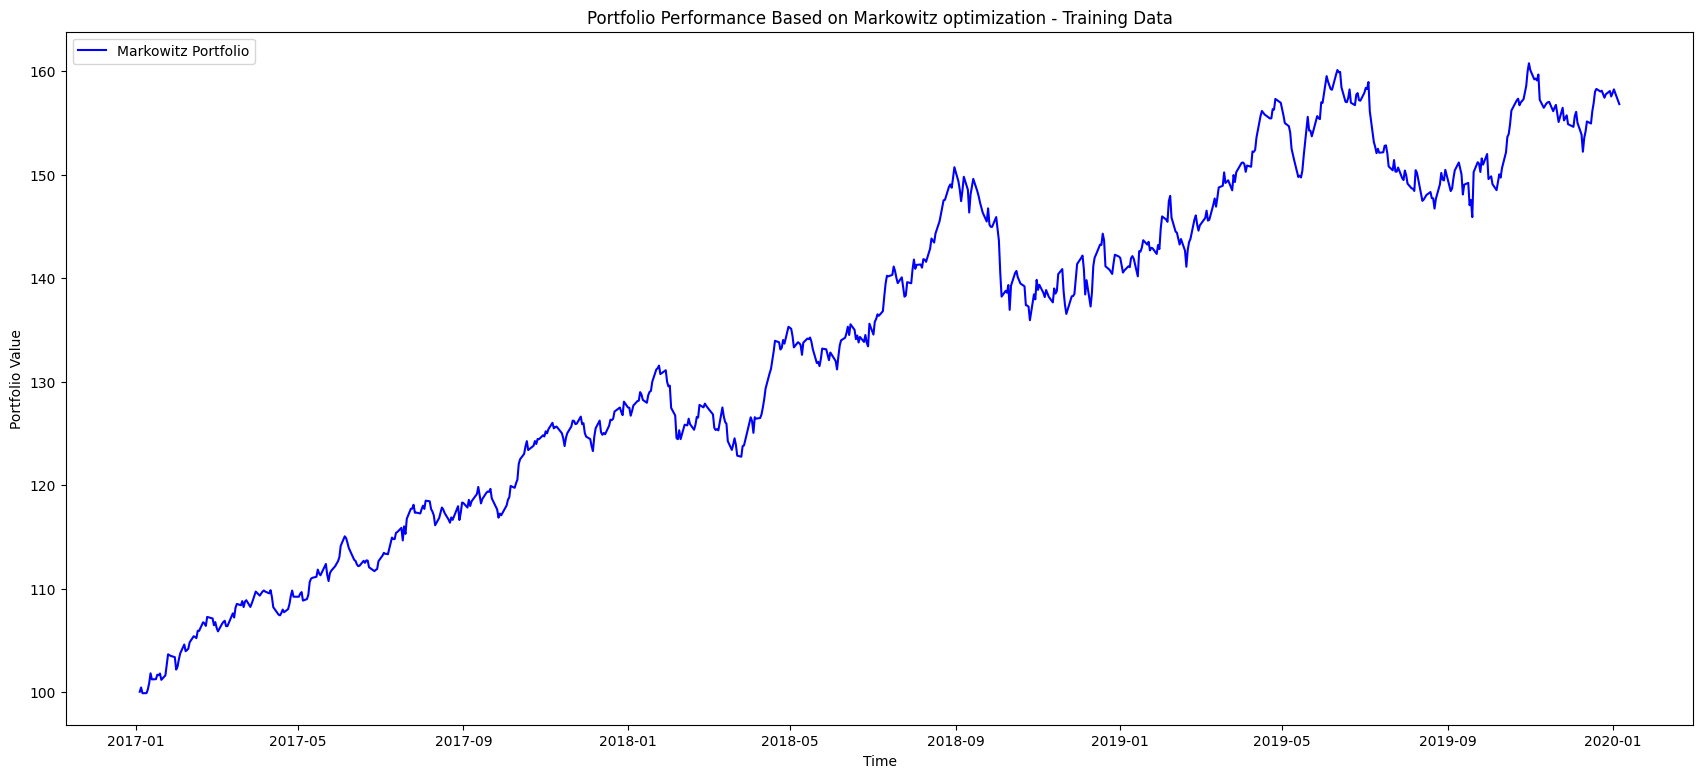

Final Portfolio Value: 156.84
Total Return: 56.84
Annualized Return: 16.56%
Sharpe Ratio: 1.6079
Maximum Drawdown (%): -9.8078


In [ ]:
%matplotlib inline

capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(np.array(list(weights_markow.values())), returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(list(returns_train_data.index[1:]), portfolio_values, label="Markowitz Portfolio", color="blue")
plt.title("Portfolio Performance Based on Markowitz optimization - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_markow"] = portfolio_returns
# Calculate performance metrics
final_value_trg_markow = capital
total_return_trg_markow = final_value_trg_markow - initial_capital
sharpe_ratio_trg_markow = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_markow = (final_value_trg_markow / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_markow = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_markow:.2f}")
print(f"Total Return: {total_return_trg_markow:.2f}")
print(f"Annualized Return: {annualized_return_trg_markow*100 :.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_markow:.4f}")
print(f"Maximum Drawdown (%): {maxdraw_trg_markow:.4f}")

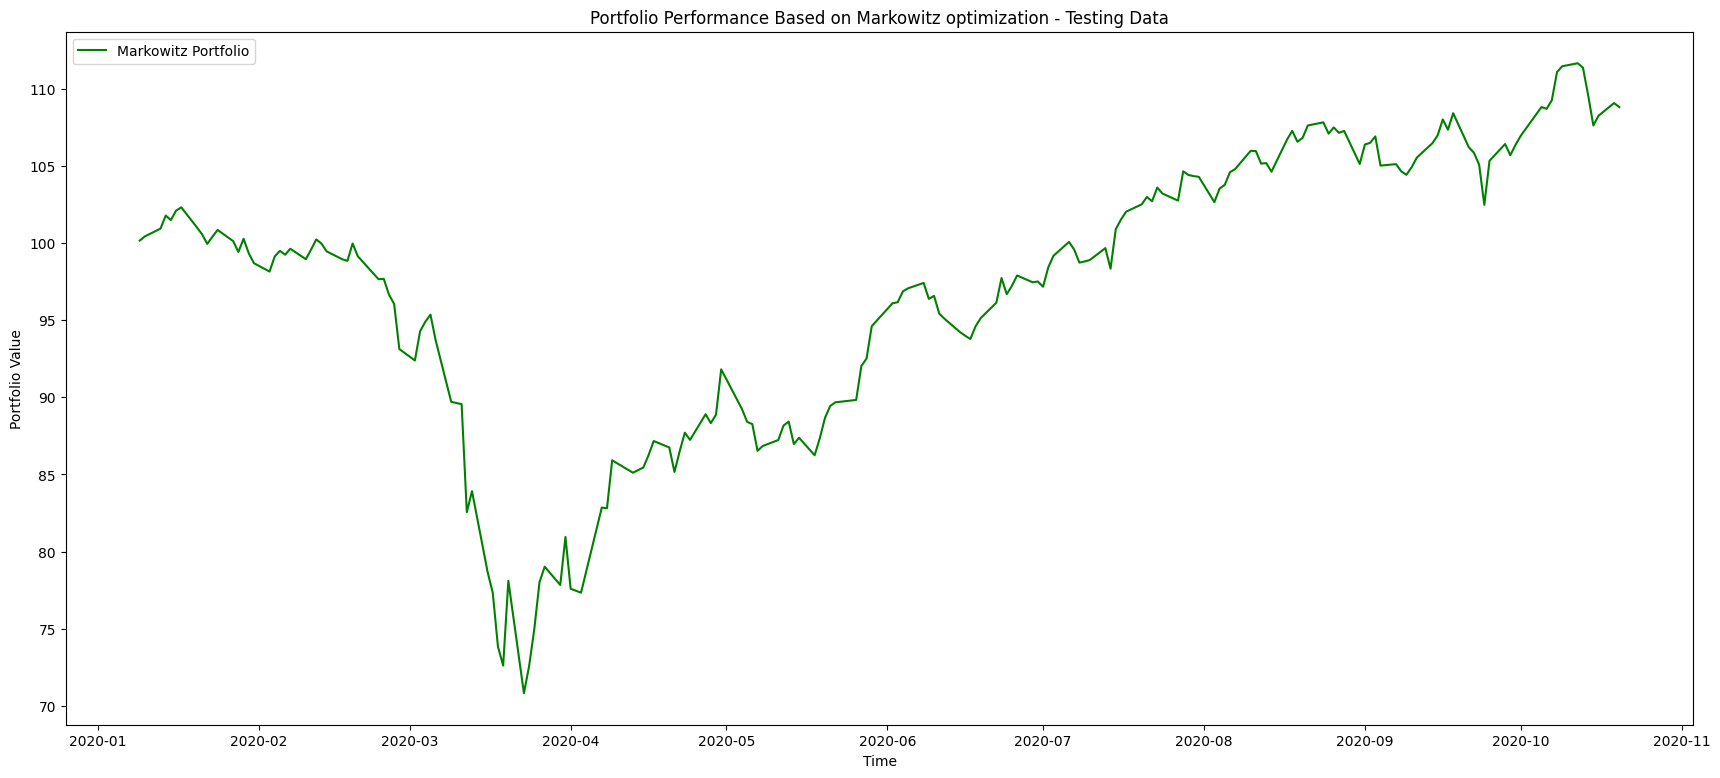

Final Portfolio Value: 108.80
Total Return: 8.80
Annualized Return: 11.45%
Sharpe Ratio: 0.5636
Maximum draw down(%): -30.7697


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []


for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(np.array(list(weights_markow.values())), returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Markowitz Portfolio", color="green")
plt.title("Portfolio Performance Based on Markowitz optimization - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_markow"] = portfolio_returns

# Calculate performance metrics
returns_test_markow = pd.DataFrame(portfolio_returns)
final_value_test_markow = capital
total_return_test_markow = final_value_test_markow - initial_capital
sharpe_ratio_test_markow = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_markow = (final_value_test_markow / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_markow = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_markow:.2f}")
print(f"Total Return: {total_return_test_markow:.2f}")
print(f"Annualized Return: {annualized_return_test_markow * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_markow:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_markow:.4f}")

## **B. Kelly's Criterion for Portfolio Optimization**

In [ ]:
# We determine the weights as per Kelly's criteria

variances = returns_train_data.var()  # Variance of returns
expected_returns = returns_train_data.mean()
# Step 2: Calculate Kelly Criterion for each security
kelly_fractions = expected_returns / variances
kelly_fractions_normalized = kelly_fractions / kelly_fractions.sum()
weights_kelly = kelly_fractions_normalized

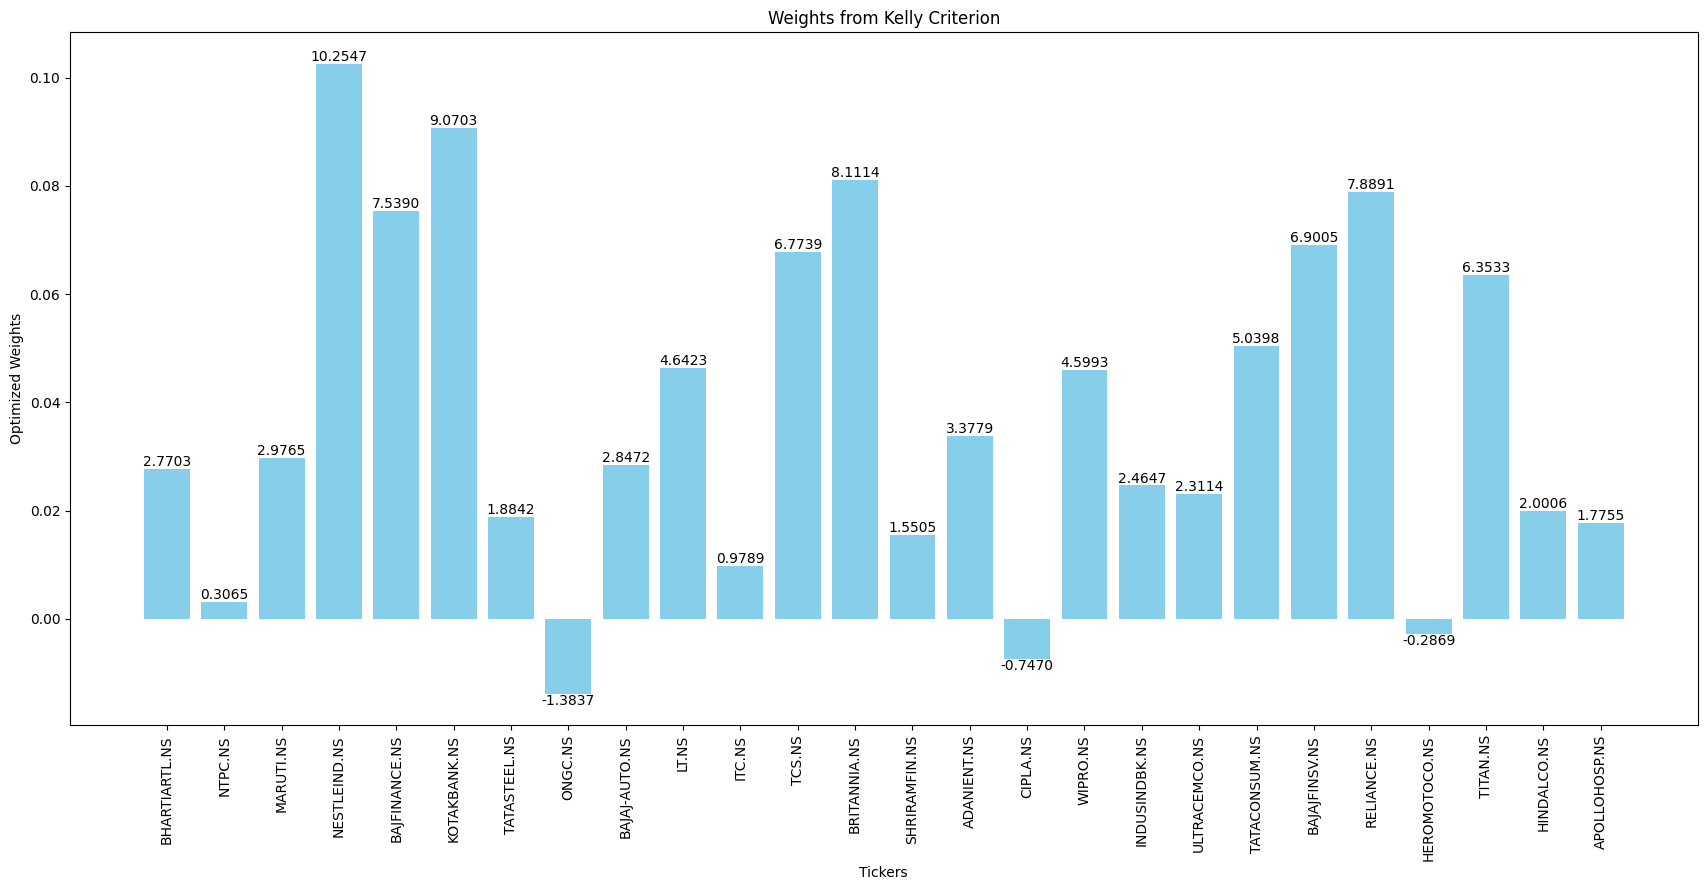

In [ ]:
# Plot the weights
plt.figure(figsize=(21, 9))
bar = plt.bar(list(weights_kelly.index), list(weights_kelly), color='skyblue')
plt.xlabel("Tickers")
plt.xticks(list(weights_kelly.index))
plt.ylabel("Optimized Weights")
plt.title("Weights from Kelly Criterion")
plt.bar_label(bar, labels=[f'{x*100:,.4f}' for x in bar.datavalues])
plt.xticks(rotation=90)
plt.show()

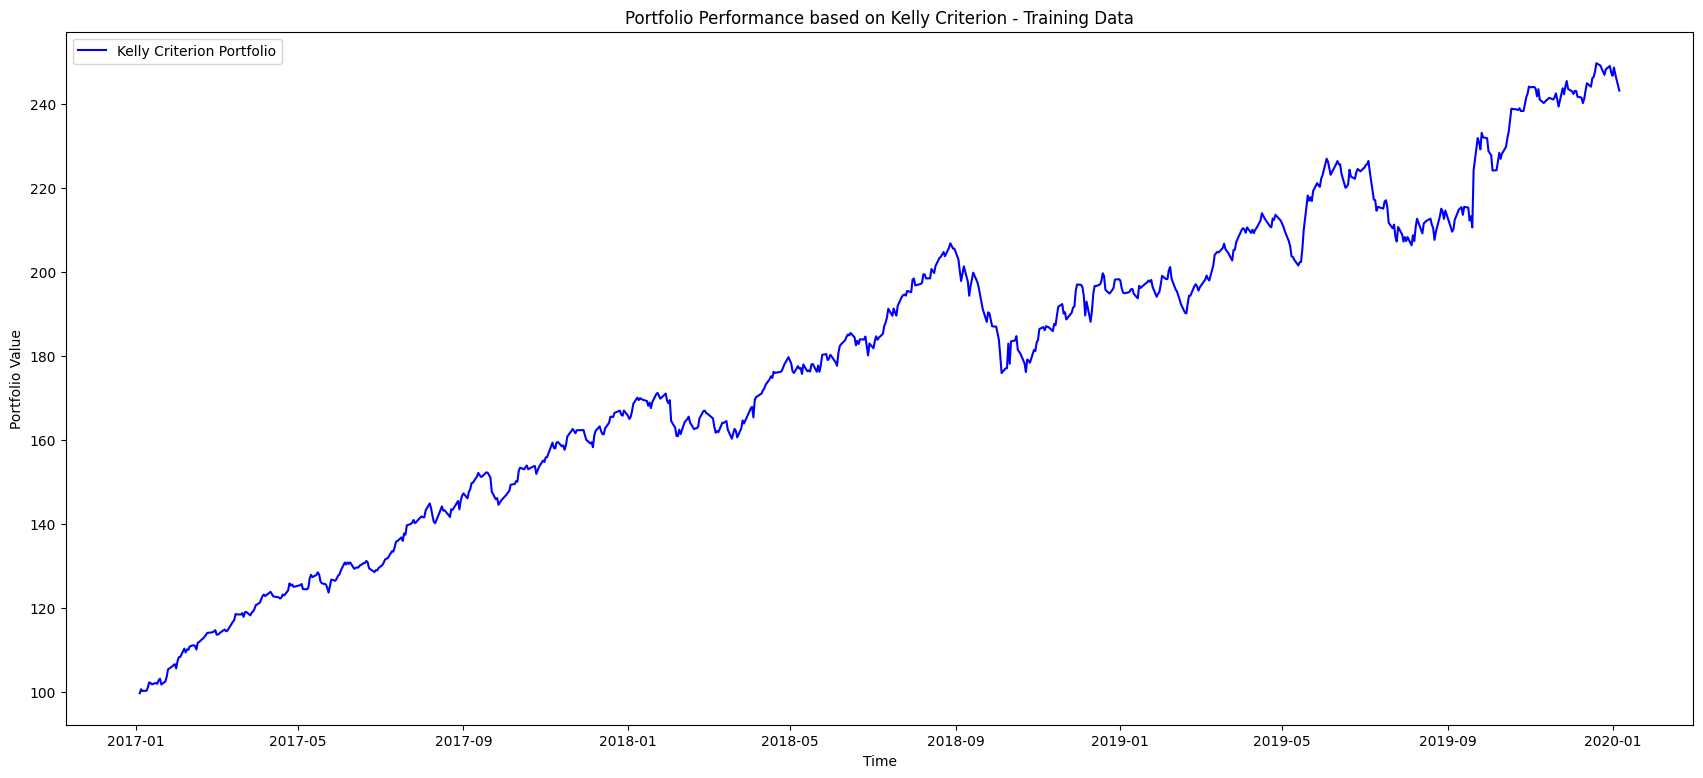

Final Portfolio Value: 243.25
Total Return: 143.25
Annualized Return: 35.35%
Sharpe Ratio: 2.2963
Maximum draw down(%): -14.9377


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_kelly, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Kelly Criterion Portfolio", color="blue")
plt.title("Portfolio Performance based on Kelly Criterion - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_kelly"] = portfolio_returns

# Calculate performance metrics
final_value_trg_kelly = capital
total_return_trg_kelly = final_value_trg_kelly - initial_capital
sharpe_ratio_trg_kelly = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_kelly = (final_value_trg_kelly / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_kelly = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_kelly:.2f}")
print(f"Total Return: {total_return_trg_kelly:.2f}")
print(f"Annualized Return: {annualized_return_trg_kelly * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_kelly:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_kelly:.4f}")

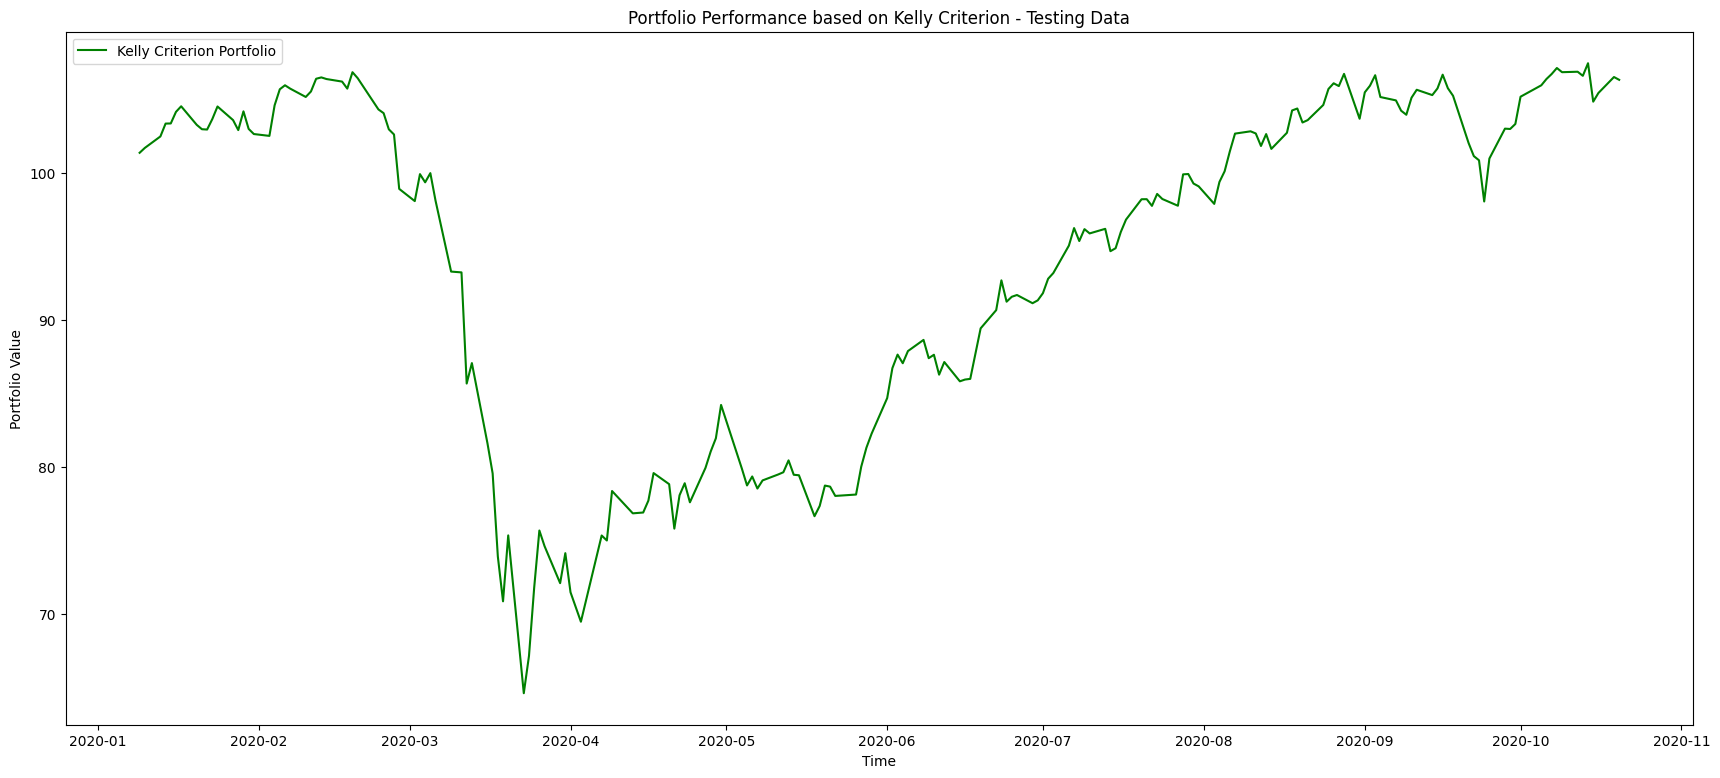

Final Portfolio Value: 106.32
Total Return: 6.32
Annualized Return: 8.19%
Sharpe Ratio: 0.4393
Maximum draw down(%): -39.5169


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_kelly, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Kelly Criterion Portfolio", color="green")
plt.title("Portfolio Performance based on Kelly Criterion - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_kelly"] = portfolio_returns


# Calculate performance metrics
final_value_test_kelly = capital
total_return_test_kelly = final_value_test_kelly - initial_capital
sharpe_ratio_test_kelly = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_kelly = (final_value_test_kelly / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_kelly = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_kelly:.2f}")
print(f"Total Return: {total_return_test_kelly:.2f}")
print(f"Annualized Return: {annualized_return_test_kelly * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_kelly:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_kelly:.4f}")

## **C. De Prado's Denoising Approach**

sse:20.67425399836205
sse:20.674257999264352
sse:61605801623.72755
sse:61482774591.7694
sse:57.77712283310765
sse:57.777118744191405
sse:26.238089458984735
sse:26.23808813564139
sse:20.31472341713144
sse:20.31472015016255
sse:19.825673244598946
sse:19.825673348434602
sse:19.82501820246087
sse:19.8250182214175
sse:19.82499557328446
sse:19.82499557332229
sse:19.82499557321314
sse:19.824995573213158
found errPDFs0.4956257532295155


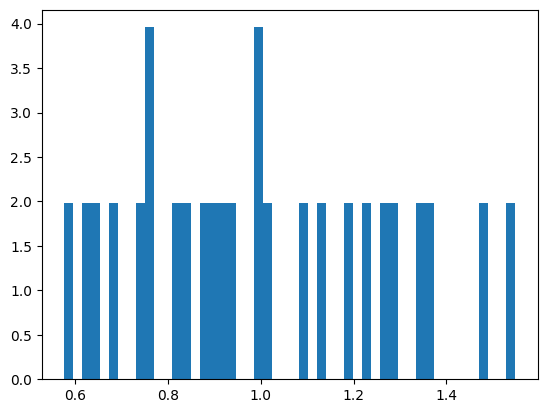

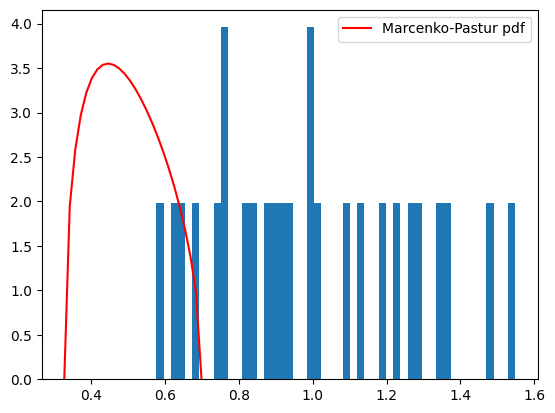

In [ ]:
N = returns_train_data.shape[1]
T = returns_train_data.shape[0]
x = returns_train_data.copy()
# code snippet 2.2 - marcenko-pastur pdf explains eigenvalues of random matrix x
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor )
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.005) #empirical pdf

# code snippet 2.3 - random matrix with signal
alpha, nCols, nFact, q = .995, N, 100, 10
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)
#pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

# Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)

#code snippet 2.3 - with random matrix with signal
######################
# Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
#plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
#plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()
######################

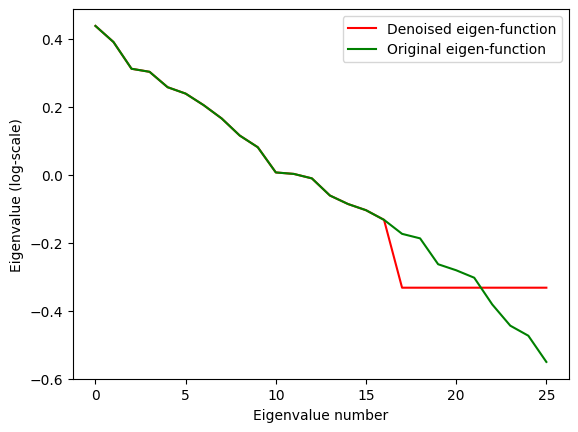

<ipython-input-79-fa19788a7d41>:21: RuntimeWarning: invalid value encountered in log
  plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")


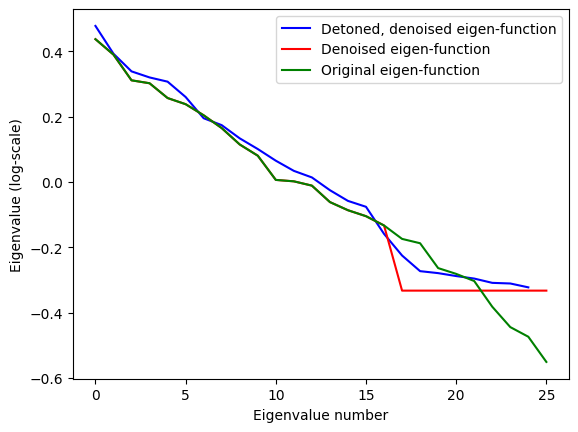

In [ ]:
# code snippet 2.5 - denoising by constant residual eigenvalue
corr1 = denoisedCorr(eVal01, eVec01, nFacts0)
eVal1, eVec1 = getPCA(corr1)

denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

corr_detoned_denoised = detoned_corr(corr1, eVal1, eVec1)

eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)

plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
std = np.sqrt(np.diag(returns_train_data.cov()))
cov_denoised = corr2cov(corr1, std)
weights_denoised = optPort(cov_denoised, returns_train_data.mean())

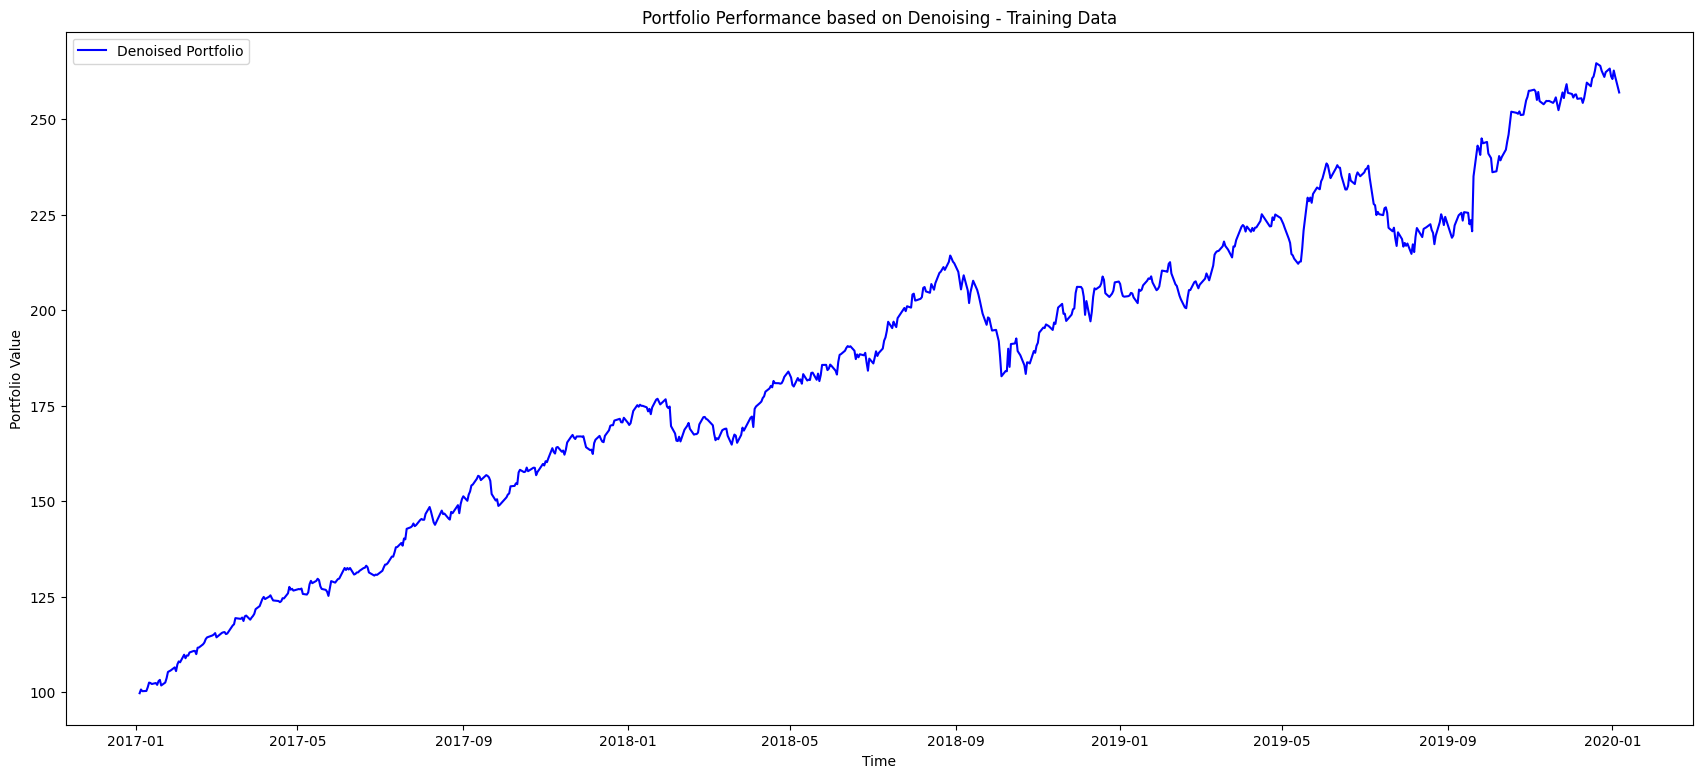

Final Portfolio Value: 256.99
Total Return: 156.99
Annualized Return: 37.91%
Sharpe Ratio: 2.3859
Maximum draw down(%): -14.7513


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_denoised, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Denoised Portfolio", color="blue")
plt.title("Portfolio Performance based on Denoising - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_denoised"] = portfolio_returns

# Calculate performance metrics
final_value_trg_denoised = capital
total_return_trg_denoised = final_value_trg_denoised - initial_capital
sharpe_ratio_trg_denoised = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_denoised = (final_value_trg_denoised / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_denoised = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_denoised:.2f}")
print(f"Total Return: {total_return_trg_denoised:.2f}")
print(f"Annualized Return: {annualized_return_trg_denoised * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_denoised:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_denoised:.4f}")

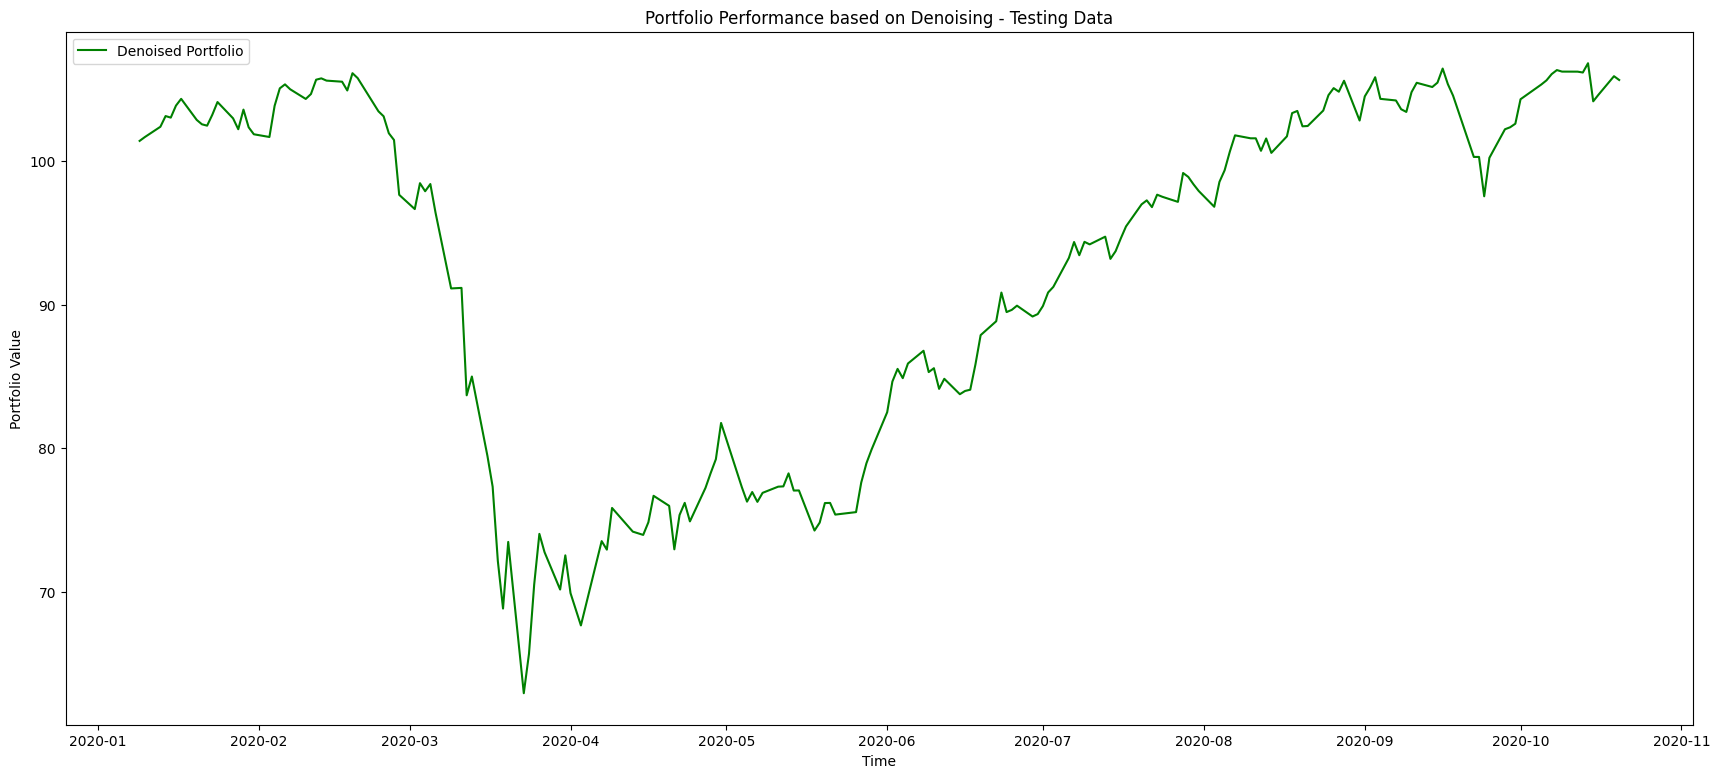

Final Portfolio Value: 105.63
Total Return: 5.63
Annualized Return: 7.29%
Sharpe Ratio: 0.4158
Maximum draw down(%): -40.6573


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_denoised, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Denoised Portfolio", color="green")
plt.title("Portfolio Performance based on Denoising - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_denoised"] = portfolio_returns

# Calculate performance metrics
final_value_test_denoised = capital
total_return_test_denoised = final_value_test_denoised - initial_capital
sharpe_ratio_test_denoised = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_denoised = (final_value_test_denoised / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_denoised = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_denoised:.2f}")
print(f"Total Return: {total_return_test_denoised:.2f}")
print(f"Annualized Return: {annualized_return_test_denoised * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_denoised:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_denoised:.4f}")

## **D. Equal-weighted Approach**

In [ ]:
weights_eq = np.ones(len(tickers_wo_cash))/len(tickers_wo_cash)

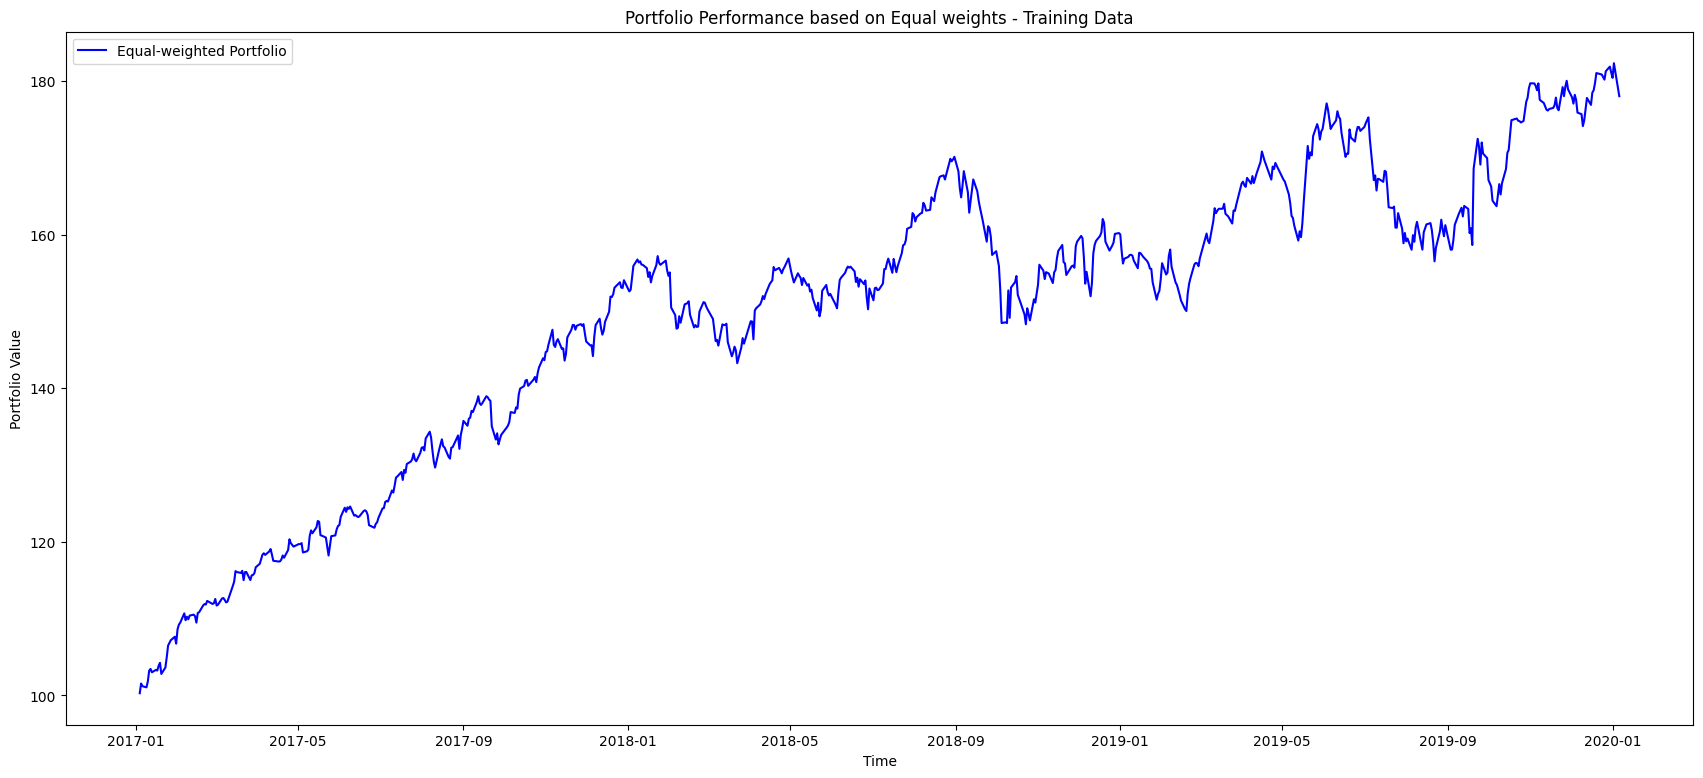

Final Portfolio Value: 178.03
Total Return: 78.03
Annualized Return: 21.70%
Sharpe Ratio: 1.5355
Maximum draw down(%): -12.8146


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_eq, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Equal-weighted Portfolio", color="blue")
plt.title("Portfolio Performance based on Equal weights - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_eq"] = portfolio_returns

# Calculate performance metrics
final_value_trg_eq = capital
total_return_trg_eq = final_value_trg_eq - initial_capital
sharpe_ratio_trg_eq = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_eq = (final_value_trg_eq / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_eq = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_eq:.2f}")
print(f"Total Return: {total_return_trg_eq:.2f}")
print(f"Annualized Return: {annualized_return_trg_eq * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_eq:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_eq:.4f}")

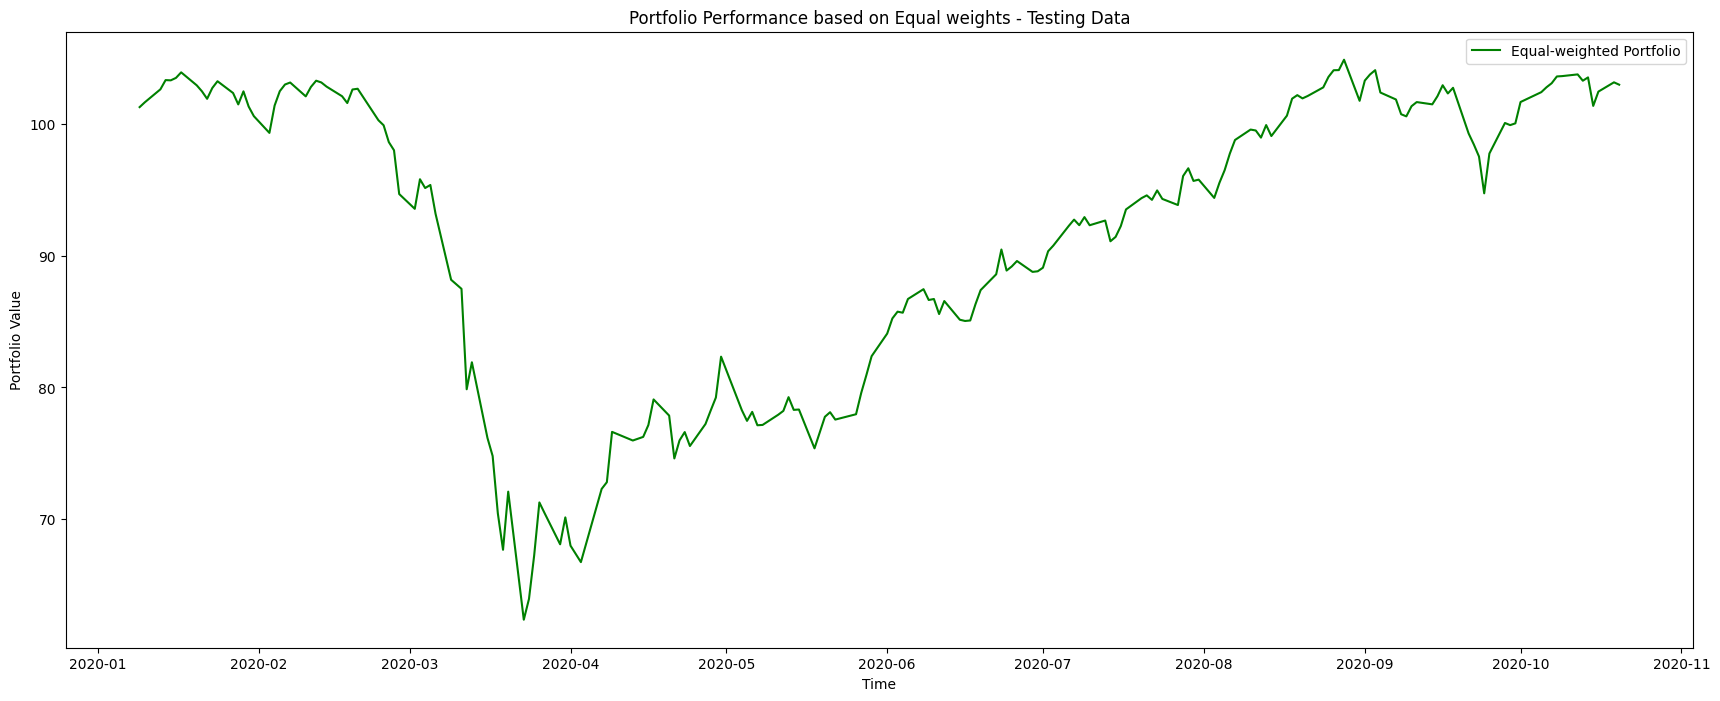

Final Portfolio Value: 103.01
Total Return: 3.01
Annualized Return: 3.89%
Sharpe Ratio: 0.3240
Maximum draw down(%): -40.0252


In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_eq, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 8))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Equal-weighted Portfolio", color="green")
plt.title("Portfolio Performance based on Equal weights - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_eq"] = portfolio_returns

# Calculate performance metrics
final_value_test_eq = capital
total_return_test_eq = final_value_test_eq - initial_capital
sharpe_ratio_test_eq = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_eq = (final_value_test_eq / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_eq = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_eq:.2f}")
print(f"Total Return: {total_return_test_eq:.2f}")
print(f"Annualized Return: {annualized_return_test_eq * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_eq:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_eq:.4f}")